In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set image size based on your data (resize if necessary)
IMAGE_SIZE = (121, 149, 121)  # Assuming 3D images; adjust as necessary
BATCH_SIZE = 8

In [ ]:
# Load CSV
csv_file = '/content/drive/MyDrive/merged.csv'  # Replace with your CSV file path
data = pd.read_csv(csv_file)


In [ ]:
# Extract file paths and age labels
file_paths = data['New_Column'].values  # Replace with the actual column name for file paths
ages = data['AGE'].values

In [ ]:
# Ensure all file paths are correct
# Check for missing or invalid file paths and convert everything to string
file_paths = [str(file).strip() for file in file_paths if isinstance(file, str) or not pd.isnull(file)]


In [ ]:
# Add the directory path where the images are stored (adjust to your image directory)
image_directory = '/content/drive/MyDrive/IXI-T1'  # Replace with your actual directory path
file_paths = [os.path.join(image_directory, file) for file in file_paths if file]


In [ ]:
print("Sample file paths:", file_paths[:5])

Sample file paths: ['/content/drive/MyDrive/IXI-T1/IXI002-Guys-0828-T1.nii.gz', '/content/drive/MyDrive/IXI-T1/IXI012-HH-1211-T1.nii.gz', '/content/drive/MyDrive/IXI-T1/IXI013-HH-1212-T1.nii.gz', '/content/drive/MyDrive/IXI-T1/IXI014-HH-1236-T1.nii.gz', '/content/drive/MyDrive/IXI-T1/IXI015-HH-1258-T1.nii.gz']


In [ ]:
# Check and adjust lengths before train-test split
min_length = min(len(file_paths), len(ages))
file_paths = file_paths[:min_length]  # Trim to the minimum length
ages = ages[:min_length]

In [ ]:
# Train-test split
file_paths_train, file_paths_test, ages_train, ages_test = train_test_split(file_paths, ages, test_size=0.2, random_state=42)


In [ ]:
# Custom data generator for 3D images
class MRIImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, ages, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True):
        self.file_paths = file_paths
        self.ages = ages
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_file_paths = [self.file_paths[i] for i in batch_indexes]
        batch_ages = [self.ages[i] for i in batch_indexes]

        # Generate data
        X, y = self.__data_generation(batch_file_paths, batch_ages)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.file_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_file_paths, batch_ages):
        X = np.empty((self.batch_size, *self.image_size, 1))  # 1 for grayscale channel
        y = np.empty((self.batch_size), dtype=float)

        # Load and preprocess each image
        for i, file_path in enumerate(batch_file_paths):
            img = nib.load(file_path).get_fdata()
            img = np.array(img)

            # Normalize the image
            img = img / np.max(img) if np.max(img) != 0 else img

            # Pad the image if necessary to match the target size
            img_padded = np.pad(
                img,
                [
                    (0, max(0, IMAGE_SIZE[0] - img.shape[0])),
                    (0, max(0, IMAGE_SIZE[1] - img.shape[1])),
                    (0, max(0, IMAGE_SIZE[2] - img.shape[2]))
                ],
                mode='constant',
                constant_values=0
            )
            img_padded = img_padded[:IMAGE_SIZE[0], :IMAGE_SIZE[1], :IMAGE_SIZE[2]]

            # Add grayscale channel
            X[i, :, :, :, 0] = img_padded
            y[i] = batch_ages[i]

        return X, y

In [ ]:
# Instantiate the data generators for training and testing
train_generator = MRIImageDataGenerator(file_paths_train, ages_train, batch_size=BATCH_SIZE)
test_generator = MRIImageDataGenerator(file_paths_test, ages_test, batch_size=BATCH_SIZE)


In [ ]:
# Define a simple 3D CNN model
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(121, 145, 121, 1)),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'),
        tf.keras.layers.MaxPooling3D((2, 2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')  # Regression task
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])

    return model

In [ ]:
# Create the model
model = create_cnn_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model using the generators
history=model.fit(train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - loss: 31.3452 - mae: 31.3452 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 832s 13s/step - loss: 31.2128 - mae: 31.2128 - val_loss: 14.9902 - val_mae: 14.9902
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - loss: 15.3587 - mae: 15.3587 - val_loss: 17.4776 - val_mae: 17.4776
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - loss: 15.7142 - mae: 15.7142 - val_loss: 14.1337 - val_mae: 14.1337
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - loss: 12.9995 - mae: 12.9995 - val_loss: 14.0517 - val_mae: 14.0517
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - loss: 14.5330 - mae: 14.5330 - val_loss: 13.3660 - val_mae: 13.3660
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - loss: 13.5451 - mae: 13.5451 - val_loss: 13.8024 - val_mae: 13.8024
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - loss: 12.9542 - mae: 12.9542 - val_loss: 13.7336 - val_mae: 13.7336
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - loss: 11.1920 - mae: 11.1920 - val_loss: 10.9806 - val_mae: 10.9806
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 205s

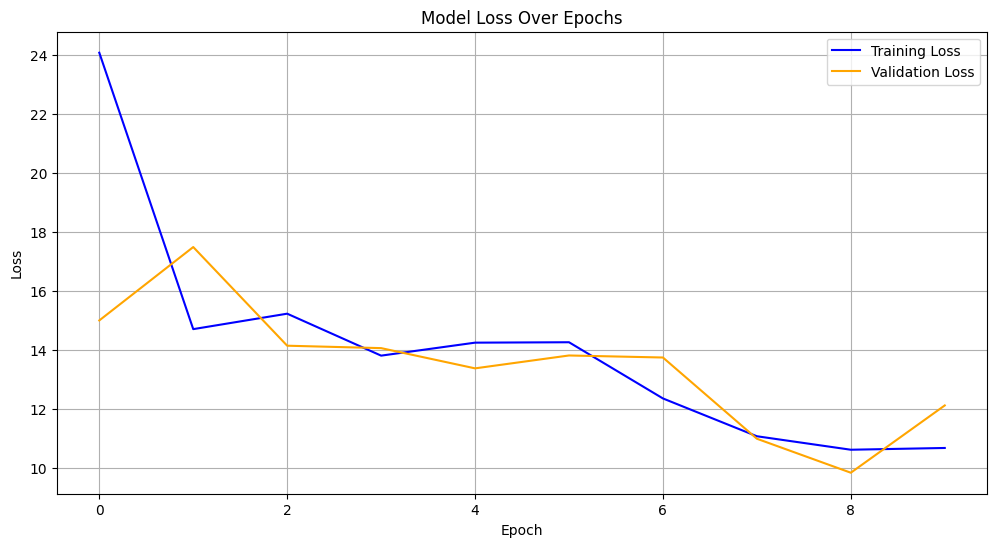

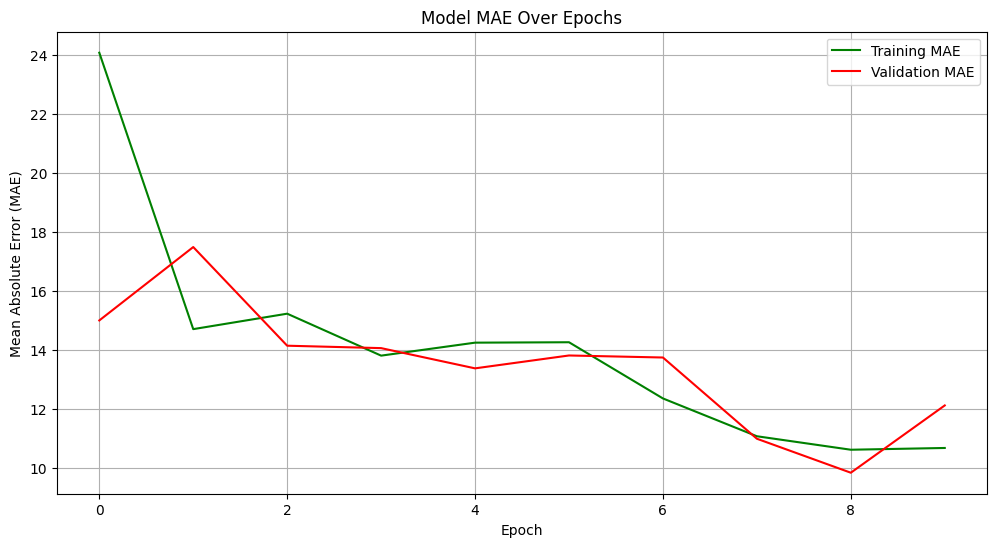

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', color='green')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.title('Model MAE Over Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(test_generator)
print(f'Test MAE: {test_mae}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 11.5780 - mae: 11.5780
Test MAE: 11.665410041809082


In [ ]:
# Save the entire model
model_path = '/content/drive/MyDrive/saved_model.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/saved_model.h5


In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = nib.load(image_path).get_fdata()
    img_data = img / np.max(img) if np.max(img) != 0 else img  # Normalize
    img_data = np.pad(img_data, [(0, max(0, IMAGE_SIZE[0] - img_data.shape[0])),
                                  (0, max(0, IMAGE_SIZE[1] - img_data.shape[1])),
                                  (0, max(0, IMAGE_SIZE[2] - img_data.shape[2]))],
                      mode='constant', constant_values=0)
    img_data = img_data[:IMAGE_SIZE[0], :IMAGE_SIZE[1], :IMAGE_SIZE[2]]  # Crop if needed
    img_data = np.expand_dims(img_data, axis=-1)  # Add channel dimension
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    return img_data

# Function to predict age from the image using the model
def predict_age_from_image(model, image_path):
    img_data = load_and_preprocess_image(image_path)
    predicted_age = model.predict(img_data)
    return predicted_age[0][0]  # Return the predicted age value

# Example usage
test_image_path = '/content/drive/MyDrive/IXI-T1/IXI085-Guys-0759-T1.nii.gz'  # Replace with your image path
predicted_age = predict_age_from_image(model, test_image_path)
print(f"Predicted Age for the given test image: {predicted_age:.2f}")

# Predict on a training image (optional)
train_image_path = '/content/drive/MyDrive/IXI-T1/IXI079-HH-1388-T1.nii.gz'  # Replace with a training image path
train_image_data = load_and_preprocess_image(train_image_path)
predicted_age_train = model.predict(train_image_data)
print(f"Predicted Age for training image: {predicted_age_train[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Age for the given test image: 47.94
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Age for training image: 42.91


In [ ]:
# To load and use the saved model for prediction:
loaded_model = tf.keras.models.load_model(model_path)
predicted_age_loaded = predict_age_from_image(loaded_model, test_image_path)
print(f"Predicted Age from loaded model: {predicted_age_loaded:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Age from loaded model: 0.02
